In [1]:
# Imports
import nltk
import csv
import re
import pandas as pd  
import numpy as np
from pprint import pprint
import math
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# Preprocessing the text

negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

class Splitter(object):
    def __init__(self):
        self.nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer()
    def split(self, text):
        sentences = self.nltk_splitter.tokenize(text)
        tokenized_sentences = [self.nltk_tokenizer.tokenize(sent) for sent in sentences]
        return tokenized_sentences

class POSTagger(object):
    def __init__(self):
        pass
    def pos_tag(self, sentences):
        pos = [nltk.pos_tag(sentence) for sentence in sentences]
        pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
        return pos
    
splitter = Splitter()
tok = WordPunctTokenizer()
postagger = POSTagger()
stemmer = SnowballStemmer("english")

pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def review_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    lower_case=""
    for i in range(0,len(text)):
        if text[i].isalpha():
            lower_case=lower_case+text[i].lower()
        elif text[i].isdigit():
            lower_case=lower_case
        else:
            lower_case=lower_case+text[i]
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    forpos= " ".join(words).strip()
    splitted_sentences = splitter.split(forpos)
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)
    altered_text=""
    for sentences in pos_tagged_sentences:
        for word in sentences:
            v=word[2]
            for val in v:
                if (val=="JJ" or val=="JJR" or val=="JJS" or val=="VB" or val=="VBD" or val=="VBG"
                    or val=="VBN" or val=="VBP" or val=="VBZ" or val=="RB" or val=="RBR" or val=="RBS" ):
                    altered_text = altered_text + stemmer.stem(word[0]) + " "
    return altered_text

In [2]:
# Store amazon reviews file in pandas dataframe
cols = ['sno','reviewerID','asin','reviewerName','helpful__001','helpful__002','reviewText','overall','summary','unixReviewTime','reviewTime','label','rating']
df = pd.read_csv("lreviews.csv",header=None, names=cols)
#print(df)
df.drop(['sno','reviewerID','asin','reviewerName','helpful__001','helpful__002','overall','summary','unixReviewTime','reviewTime','label'],axis=1,inplace=True)
#print(df)

In [3]:
# Create clean review file 
clean_review_texts = np.empty([1, 2], dtype=object)
for i in range(0,6000):      
    clean_review_texts=np.append(clean_review_texts, np.array([[review_cleaner(df.iloc[i]['reviewText']),df.iloc[i]['rating']]]), axis=0)
clean_review_texts=np.delete(clean_review_texts, 0, 0)
clean_df = pd.DataFrame(clean_review_texts,columns=['text','target'])    
clean_df.to_csv('lclean_review.csv',encoding='utf-8')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

my_df = pd.read_csv('lclean_review.csv',index_col=0)

# Create term frequency file
cvec = CountVectorizer(dtype='float32')
#cvec.fit(my_df.text)
cvec.fit_transform(my_df['text'].values.astype('U'))
print(len(cvec.get_feature_names()))
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text.values.astype('U'))
neu_doc_matrix = cvec.transform(my_df[my_df.target == 2].text.values.astype('U'))
pos_doc_matrix = cvec.transform(my_df[my_df.target == 4].text.values.astype('U'))
neg_tf = np.sum(neg_doc_matrix,axis=0)
neu_tf = np.sum(neu_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray((neg_tf)))
neu = np.squeeze(np.asarray((neu_tf)))
pos = np.squeeze(np.asarray((pos_tf)))

term_freq_df = pd.DataFrame([neg,neu,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()
term_freq_df.columns = ['negative','neutral', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['neutral'] +term_freq_df['positive']
#document_matrix = cvec.transform(my_df.text)
term_freq_df.to_csv('lterm_freq.csv',encoding='utf-8')


term_freq_df_new = pd.read_csv('lterm_freq.csv',index_col=0)
#print(term_freq_df_new)
lexicon_df = pd.DataFrame([neg,neu,pos],columns=cvec.get_feature_names()).transpose()
lexicon_df.columns = ['negative','neutral', 'positive']
for i in range(0, len(cvec.get_feature_names())):
    tot=term_freq_df_new.iloc[i]['total']
    nn=term_freq_df_new.iloc[i]['negative']
    nu=term_freq_df_new.iloc[i]['neutral']
    ps=term_freq_df_new.iloc[i]['positive']
    if nn==0:
        lexicon_df.iloc[i]['negative']=0
    elif nn==tot:
        lexicon_df.iloc[i]['negative']=2.5*nn
    else:
        lexicon_df.iloc[i]['negative']=1/(math.log((tot/nn),10))
    if nu==0:
        lexicon_df.iloc[i]['neutral']=0
    elif nu==tot:
        lexicon_df.iloc[i]['neutral']=2.5*nu
    else:
        lexicon_df.iloc[i]['neutral']=1/(math.log((tot/nu),10))
    if ps==0:
        lexicon_df.iloc[i]['positive']=0
    elif ps==tot:
        lexicon_df.iloc[i]['positive']=2.5*ps
    else:
        lexicon_df.iloc[i]['positive']=1/(math.log((tot/ps),10))
        #print(1/(math.log((tot/ps),10)))
        #print(float(lexicon_df.iloc[i]['positive']))

lexicon_df.to_csv('llexicon.csv',encoding='utf-8') 

4963


In [5]:
# Create final features file from generated lexicon
createfeed=pd.read_csv('llexicon.csv',index_col=0)
columns=["Sno","freq_neg","freq_neutral","freq_pos","overall"]
with open('lsixthousandfeed.csv','w', newline='') as myfile:
    wr = csv.writer(myfile,quoting=csv.QUOTE_NONE)
    wr.writerow(columns)
    for i in range(0,6000):
        feature_values=[0,0,0]
        text_for_comparison = my_df.iloc[i]['text']
        words= text_for_comparison.split()
        for j in range(0,len(words)):
            feature_values = np.add(feature_values,[createfeed.loc[words[j]][0],createfeed.loc[words[j]][1],createfeed.loc[words[j]][2]])
        feature_values = feature_values.tolist()
        feature_values.insert(0, i)
        new_lab=int(my_df.iloc[i]['target'] / 2)
        feature_values.insert(4, new_lab)
        wr.writerow(feature_values)

In [6]:
import keras
import numpy as np
from keras.utils import to_categorical

# Read final input data to numpy array
with open('lsixthousandfeed.csv') as f:
    content = f.readlines()
lines = np.array(content) 
num_of_instances = lines.size

C:\Users\apurv\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
x_train, y_train, y_train_svm = [], [], []
for i in range(1, num_of_instances):
    val = [0, 0, 0]
    sno, val[0], val[1], val[2], label = lines[i].split(",")
    final_val = np.array(val, 'float32')
    class_label = keras.utils.to_categorical(label, 3)
    y_train_svm.append(label)
    y_train.append(class_label)
    x_train.append(final_val)

In [8]:
x_train = np.array(x_train)
print(np.shape(x_train))
y_train = np.array(y_train)
print(y_train[1])

(6000, 3)
[0. 0. 1.]


In [9]:
# Shuffle the data
from random import shuffle
ind_list = [i for i in range(len(x_train))]
shuffle(ind_list)
x_train = x_train[ind_list,]
y_train = y_train[ind_list,]
i = 0
y_train_svm2 = []
for j in ind_list:
    y_train_svm2.append(y_train_svm[j])
    i += 1

In [22]:
# Neural network classification

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

model=Sequential()

model.add(Dense(8,input_shape=(3,)))
model.add(Activation("sigmoid"))

model.add(Dense(3))
model.add(Activation("softmax"))

In [23]:
model.compile(optimizer=keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=40, batch_size=128, verbose=1, validation_split=0.2)

Train on 4800 samples, validate on 1200 samples
Epoch 1/40
4800/4800 [==============================] - 1s 113us/step - loss: 1.2794 - acc: 0.1954 - val_loss: 1.1811 - val_acc: 0.2000
Epoch 2/40
4800/4800 [==============================] - 0s 12us/step - loss: 1.1127 - acc: 0.2371 - val_loss: 1.0436 - val_acc: 0.2083
Epoch 3/40
4800/4800 [==============================] - 0s 14us/step - loss: 0.9784 - acc: 0.4890 - val_loss: 0.9168 - val_acc: 0.6875
Epoch 4/40
4800/4800 [==============================] - 0s 15us/step - loss: 0.8692 - acc: 0.7121 - val_loss: 0.8374 - val_acc: 0.6867
Epoch 5/40
4800/4800 [==============================] - 0s 15us/step - loss: 0.8016 - acc: 0.7079 - val_loss: 0.7822 - val_acc: 0.6892
Epoch 6/40
4800/4800 [==============================] - 0s 14us/step - loss: 0.7518 - acc: 0.7083 - val_loss: 0.7389 - val_acc: 0.6733
Epoch 7/40
4800/4800 [==============================] - 0s 15us/step - loss: 0.7124 - acc: 0.7285 - val_loss: 0.7036 - val_acc: 0.8417
Epoch 

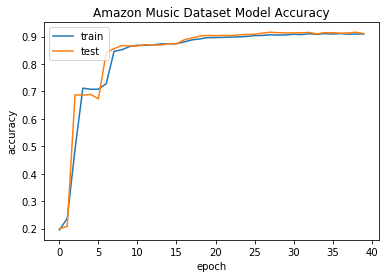

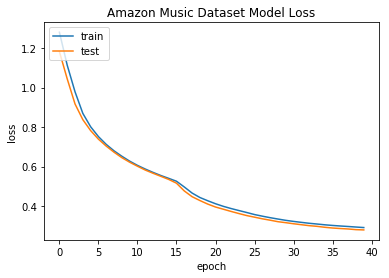

In [24]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Amazon Music Dataset Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Amazon Music Dataset Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print(len(classes))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
pred_list = []
actual_list = []
predictions = model.predict(x_train)
for i in predictions:
    pred_list.append(np.argmax(i))
for i in y_train:
    actual_list.append(np.argmax(i))
cnf_matrix=confusion_matrix(actual_list, pred_list)

Confusion matrix, without normalization
[[1134   36   56]
 [  48  932  196]
 [  76  128 3394]]
3


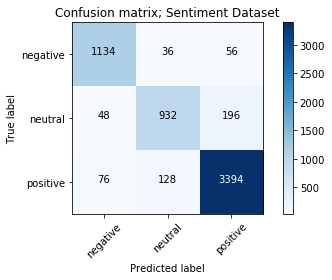

In [27]:
# Plot non-normalized confusion matrix
class_names =['negative','neutral','positive']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix; Sentiment Dataset')
plt.show()

In [28]:
# Test model on actual input
import pandas as pd
createfeed=pd.read_csv('llexicon.csv',index_col=0)
feature_values=[0,0,0]
str = "This is quite defective."
str_result =  review_cleaner(str)
words= str_result.split()
for j in range(0,len(words)):
    try:
        feature_values = np.add(feature_values,[createfeed.loc[words[j]][0],createfeed.loc[words[j]][1],createfeed.loc[words[j]][2]])
    except:
        continue
feature_values = feature_values.tolist()
test_case = np.array(feature_values)

#print(np.shape(test_case))
checker = []
checker.append(test_case)
checker = np.array(checker)
#print(np.shape(checker))

custom = model.predict(checker)
print(custom[0])

# Order: negative, neutral, positive

[0.85547674 0.03876741 0.1057559 ]


In [29]:
# Data split for other classifications
import numpy as np
from sklearn import svm, datasets, metrics
from sklearn.linear_model import LogisticRegression

X = x_train[:4800]
print(np.shape(X))
X_val = x_train[4800:]
print(np.shape(X_val))

y = y_train_svm2[:4800]
y_val = y_train_svm2[4800:]
y = list(map(int, y))
y_val = list(map(int, y_val))

(4800, 3)
(1200, 3)


In [30]:
# SVC rbf kernel
C=1.0
model = svm.SVC(kernel='rbf', gamma=0.7, C=C)
model.fit(X, y)
# training accuracy
y_pred = model.predict(X)
print(metrics.accuracy_score(y, y_pred, normalize=True, sample_weight=None))
# validation accuracy
y_pred = model.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred, normalize=True, sample_weight=None))

0.996875
0.9883333333333333


In [32]:
C=1.0

# SVC linear kernel
model = svm.SVC(kernel='linear', C=C)
model.fit(X, y)
# training accuracy
y_pred = model.predict(X)
print(metrics.accuracy_score(y, y_pred, normalize=True, sample_weight=None))
# validation accuracy
y_pred = model.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred, normalize=True, sample_weight=None))

# Linear SVC
model = svm.LinearSVC(C=C)
model.fit(X, y)
# training accuracy
y_pred = model.predict(X)
print(metrics.accuracy_score(y, y_pred, normalize=True, sample_weight=None))
# validation accuracy
y_pred = model.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred, normalize=True, sample_weight=None))

0.9060416666666666
0.9133333333333333
0.905625
0.91


In [35]:
# Logistic Regression classification

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(X, y)
# training accuracy
y_pred = logreg.predict(X)
print(metrics.accuracy_score(y, y_pred, normalize=True, sample_weight=None))
# validation accuracy
y_pred = logreg.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred, normalize=True, sample_weight=None))

0.9083333333333333
0.915


In [39]:
# Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X, y)
# training accuracy
y_pred = model.predict(X)
print(metrics.accuracy_score(y, y_pred, normalize=True, sample_weight=None))
# validation accuracy
y_pred = model.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred, normalize=True, sample_weight=None))

0.8510416666666667
0.8483333333333334
